# Analysis of the Causes of Losses for the Entertainment Application

Despite significant investments in advertising, the entertainment app's development company has been incurring losses over the past few months. 

**Research Objective:** identify the causes of the losses by the entertainment app's development company.

**Research Tasks:**

- Assess the suitability of the initial data for further analysis and conduct data preprocessing.
- Define functions for calculating and analyzing LTV, ROI, retention, and conversion rates.
- Create user profiles and determine the user acquisition period.
- Analyze the distribution of users by country, device, and acquisition channels.
- Calculate marketing expenses, including the CAC metric.
- Analyze  the profitability of the advertising campaigns based on the LTV, ROI, and CAC graphs.

## Summary of the Analysis Results

The analyzed user acquisition period is from May 1, 2019, to October 27, 2019.

The dataframe contains data about users:

- From four countries: the USA (the majority of users), the UK, France, and Germany;
- Using the following devices: iPhone (majority), Android, Mac, and PC.
  
Distribution of users by acquisition channels: the highest number of users came to the app organically, but the highest number of paying users were acquired through FaceBoom.

Marketing data analysis: high costs for the TipTop acquisition channel (more than 50% of all expenses) brought only 13% of users (including organically acquired users) or 21% (excluding them); the weekly and monthly spending dynamics and the CAC metric indicate that marketing expenses for the TipTop channel are extremely high and tend to increase rapidly, while no data supports the effectiveness of spending such large amounts on this acquisition channel.

Overall, the advertising campaign is not profitable due to high user acquisition costs for specific devices (iPhone and Mac), countries (USA), and acquisition channels (TipTop).

In the future, it is recommended to consider reducing advertising campaigns on expensive channels (TipTop) and expanding them on channels with lower acquisition costs but having ROI value highter then 1, such as lambdaMediaAds and YRabbit. Additionally, it is worth investigating whether there are technical reasons why users from the USA, as well as Mac and iPhone users, convert well to app users but quickly churn.

## Data Overview and Processing

Importing the necessary libraries for data analysis:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import numpy as np
import seaborn as sns
import json

Reading the files `orders_info_short.csv`, `costs_info_short.csv`, and `visits_info_short.csv` with the data (the path to the data is stored in a JSON file) and saving them in the variables `orders`, `ad_costs`, `visits`:

In [2]:
# Reading of JSON file
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)
    
# Reading the CSV file using the path from the JSON file
dataset_path_app_orders = config['dataset_path_app_orders']
dataset_path_app_costs = config['dataset_path_app_costs']
dataset_path_app_visits = config['dataset_path_app_visits']
orders = pd.read_csv(dataset_path_app_orders)
ad_costs = pd.read_csv(dataset_path_app_costs)
visits = pd.read_csv(dataset_path_app_visits)

Removing the restrictions on displaying the number of columns, rows, and column width.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Let's display the first few rows of the datasets and the overall information about the dataframes.

In [4]:
# Function to display the first 5 rows and information of a dataframe
def display_data(df, df_name):
    print(f"First 5 rows of the dataframe {df_name}:\n")
    print(df.head(5).to_string())
    print("\nInformation about the dataframe:\n")
    print(df.info())
    print("\n" + "="*80 + "\n")

# Main function to display data
def main():
    display_data(orders, 'orders')
    display_data(ad_costs, 'ad_costs')
    display_data(visits, 'visits')

# Running the main function
main()

First 5 rows of the dataframe orders:

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

Information about the dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


First 5 rows of the dataframe ad_costs:

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Information about the dataframe:

<class 'pandas

In the first step, let's convert the column headers to lowercase:

In [5]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
ad_costs.columns = ad_costs.columns.str.lower()

Next, let's remove spaces in column names by replacing them with underscores:

In [6]:
def replace_spaces(column_name):
    return column_name.replace(' ', '_')

visits.rename(columns=replace_spaces, inplace=True)
orders.rename(columns=replace_spaces, inplace=True)
ad_costs.rename(columns=replace_spaces, inplace=True)

There are no missing values in the data; however, columns containing date and time information need to be converted to `datetime` format:

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

Checking the explicit duplicates in the dataframes:

In [8]:
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
ad_costs.duplicated().sum()

0

Explicit duplicates among the rows of the dataframes are absent.

In general, the data for analysis is complete and does not require further preprocessing: there are no missing values, and columns containing date and time information have been converted to `datetime` format.

## Data Analysis

### Functions for calculating and analyzing LTV, ROI, retention, and conversion

Let's define functions to compute the metric values:

- `get_profiles()` — to create user profiles,
- `get_retention()` — to calculate the Retention Rate,
- `get_conversion()` — to calculate the conversion rate,
- `get_ltv()` — to calculate the LTV.

And also functions to plot graphs:

- `filter_data()` — to smooth the data,
- `plot_retention()` — to plot the Retention Rate graph,
- `plot_conversion()` — to plot the conversion graph,
- `plot_ltv_roi` — to visualize LTV and ROI.

**get_profiles()** - function for creating user profiles:

In [11]:
def get_profiles(visits, orders, ad_costs):

    # Finding the parameters of the first visits
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'region': 'first',
                'device': 'first',
                'channel': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # For cohort analysis, determining the date of the first visit
    # and the first day of the month when this visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M')

    # Adding a feature for paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # Calculating the number of unique users
    # with the same source and attraction date
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # Combining advertising expenses and the number of attracted users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # Dividing advertising expenses by the number of attracted users
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # Adding acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # The acquisition cost for organic users is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

**get_retention()** - function for calculating the Retention Rate:

In [12]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Adding the column 'payer' to the passed dimensions list
    dimensions = ['payer'] + dimensions

    # Excluding users who did not "live" until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Collecting "raw" data for retention calculation
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # Function for grouping the table by desired attributes
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # Getting the retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # Getting the retention dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # Returning both tables and raw data
    return result_raw, result_grouped, result_in_time

**get_conversion()** — function for calculating the conversion rate:

In [13]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Excluding users who did not "live" until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Determining the date and time of the first purchase for each user
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # Adding purchase data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # Calculating lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # Grouping by cohort if dimensions is empty
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # Function for grouping the table by desired attributes
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # Dividing each "cell" in the row by the cohort size
        # to get the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # Getting the conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # For the conversion dynamics table, removing 'cohort' from dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # Getting the conversion dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # Returning both tables and raw data
    return result_raw, result_grouped, result_in_time

**get_ltv()** — function for calculating the LTV:

In [14]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Excluding users who did not "live" until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # Add purchase data to profiles
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # Calculating the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # Grouping by cohort if dimensions is empty
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # Function to group by desired attributes
    def group_by_dimensions(df, dims, horizon_days):
        # Build the "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # Calculating the cumulative revenue sum
        result = result.fillna(0).cumsum(axis=1)
        # Compute cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # Merging cohort sizes and the revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # Calculating LTV: divide each "cell" in the row by the cohort size
        result = result.div(result['cohort_size'], axis=0)
        # Excluding all lifetimes exceeding the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # Restoring cohort sizes
        result['cohort_size'] = cohort_sizes

        # Creating a dataframe with user data and CAC values,
        # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # Calculating the average CAC by parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # Calculating ROI: dividing LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # Removing rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # Restoring cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # Adding CAC to the ROI table
        roi['cac'] = cac['cac']

        # In the final table, leaving cohort sizes, CAC,
        # and ROI for lifetimes not exceeding the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # Returning LTV and ROI tables
        return result, roi

    # Getting LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # For dynamic tables, removing 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # Getting dynamic LTV and ROI tables
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # Raw data
        result_grouped,  # LTV table
        result_in_time,  # Dynamic LTV table
        roi_grouped,  # ROI table
        roi_in_time,  # Dynamic ROI table
    )

**filter_data()** — function for smoothing the data:

In [15]:
def filter_data(df, window):
    # Applying a rolling mean to each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()
    return df

**plot_retention()** — function for plotting the Retention Rate graph:

In [16]:
def plot_retention(retention, retention_history, horizon, window=7):

    # Setting the size of the plot grid
    plt.figure(figsize=(15, 10))

    # Excluding cohort sizes and first-day retention
    retention = retention.drop(columns=['cohort_size', 0])
    # Keeping only the required lifetime in the retention history table
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # If the retention index has only payer,
    # adding the second attribute — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # The plot grid has two columns and two rows, four cells
    # In the first cell, plot retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # In the second cell, plot retention curves for non-paying users
    # The vertical axis is shared with the first cell plot
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # In the third cell, plot retention dynamics for paying users
    ax3 = plt.subplot(2, 2, 3)
    # Getting column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # Filtering data and plot
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition date')
    plt.title(
        'Retention dynamics of paying users on day {}'.format(
            horizon
        )
    )

    # In the fourth cell, plot retention dynamics for non-paying users
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # Filter data and plot
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Acquisition date')
    plt.title(
        'Retention dynamics of non-paying users on day {}'.format(
            horizon
        )
    )

    plt.tight_layout()
    plt.show()

**plot_conversion()** — function for plotting the conversion graph:

In [17]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # Setting the size of the plot grid
    plt.figure(figsize=(15, 5))

    # Excluding cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # Keeping only the required lifetime in the conversion history table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # First plot — conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User Conversion')

    # Second plot — conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # Pivot table columns will be all index columns except the date
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition Date')
    plt.title('User Conversion Dynamics on Day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

**plot_ltv_roi()** — function for visualisation of LTV and ROI:

In [18]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # Setting up the grid for plotting
    plt.figure(figsize=(20, 10))

    # Excluding cohort sizes from the ltv table
    ltv = ltv.drop(columns=['cohort_size'])
    # Keeping only the required lifetime in the ltv history table
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # Storing acquisition costs in a separate dataframe
    cac_history = roi_history[['cac']]

    # Excluding cohort sizes and cac from the roi table
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # Keeping only the required lifetime in the roi history table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # First plot — ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # Second plot — ltv dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # Pivot table columns will be all index columns except the date
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Acquisition Date')
    plt.title('User LTV Dynamics on Day {}'.format(horizon))

    # Third plot — cac dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # Pivot table columns will be all index columns except the date
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Acquisition Date')
    plt.title('User Acquisition Cost Dynamics')

    # Fourth plot — roi curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Breakeven Point')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # Fifth plot — roi dynamics
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # Pivot table columns will be all index columns except the date
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Breakeven Point')
    plt.xlabel('Acquisition Date')
    plt.title('User ROI Dynamics on Day {}'.format(horizon))

    plt.tight_layout()
    plt.show()

### User Profiles Creation

Let's call the `get_profiles()` function, passing it the data on app visits, purchases, and advertising costs.

In [19]:
profiles = get_profiles(visits, orders, ad_costs)
profiles.head(5)

,user_id,first_ts,region,device,channel,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,United States,Mac,FaceBoom,2019-05-07,2019-05,True,1.088172
1,4919697,2019-07-09 12:46:07,United States,iPhone,FaceBoom,2019-07-09,2019-07,False,1.107237
2,6085896,2019-10-01 09:58:33,France,iPhone,organic,2019-10-01,2019-10,False,0.000000
3,22593348,2019-08-22 21:35:48,Germany,PC,AdNonSense,2019-08-22,2019-08,False,0.988235
4,31989216,2019-10-02 00:07:44,United States,iPhone,YRabbit,2019-10-02,2019-10,False,0.230769


Determine the minimum acquisition date of users:

In [20]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

And the maximum one:

In [21]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

The minimum and maximum acquisition dates for users are May 1, 2019, and October 27, 2019, respectively, which matches the initial project data.

### Distribution of Users by Country

Let's find out which countries the users come from and which country has the most paying users:

In [22]:
# Defining the number of users broken down by country
users_by_country = profiles.pivot_table(
    index = ['region'], 
    values = ['user_id'], 
    aggfunc ='count'
).rename(columns={'user_id': 'users_count'})

# Defining the number of paying users by country
users_by_country_payers = profiles[profiles['payer'] == True].pivot_table(
    index=['region'], 
    values=['user_id'], 
    aggfunc='count'
).rename(columns={'user_id': 'payers_count'})

# Merging the two tables
merged_table = users_by_country.merge(users_by_country_payers, on='region', how='left')
sorted_table = merged_table.sort_values(by='payers_count', ascending=False)

# Adding a column with the share of paying users broken down by country
sorted_table['payers_share'] = sorted_table['payers_count']/sorted_table['users_count']*100
sorted_table['payers_share'] = sorted_table['payers_share'].round(2)
sorted_table

,users_count,payers_count,payers_share
region,,,
United States,100002,6902,6.90
UK,17575,700,3.98
France,17450,663,3.80
Germany,14981,616,4.11


Visualizing the resulting data: creating a table showing the total number of users and the number of paying users from each country.

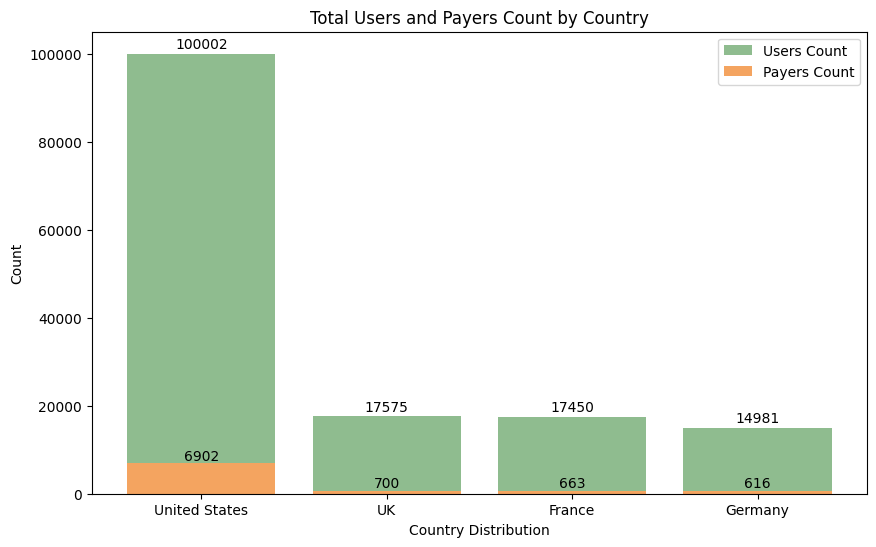

In [23]:
# Building a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Defining the width of the bars
bar_width = 0.8

# Building the users_count bar
ax.bar(sorted_table.index, sorted_table['users_count'], color='darkseagreen', label='Users Count')

# Building the payers_count bar inside users_count
ax.bar(sorted_table.index, sorted_table['payers_count'], color='sandybrown', label='Payers Count', width=bar_width)

# Configuring the legend display
ax.legend()

# Adding annotations to the bars
for i, v in enumerate(sorted_table['users_count']):
    ax.text(i, v + 500, str(v), ha='center', va='bottom')

for i, v in enumerate(sorted_table['payers_count']):
    ax.text(i, v + 100, str(v), ha='center', va='bottom')

# Configuring axes and title
ax.set_xlabel('Country Distribution')
ax.set_ylabel('Count')
ax.set_title('Total Users and Payers Count by Country')

# Displaying the chart
plt.show()

Both the highest number of users overall and paying users are located in the USA.

### Distribution of Users by Devices

Let's find out which devices clients use and which devices paying users prefer.

In [24]:
# Determining the number of users broken down by device used
users_by_device = profiles.pivot_table(
    index=['device'],
    values=['user_id'],
    aggfunc='count'
).rename(columns={'user_id': 'users_count'})

# Determining the number of paying users broken down by device used
users_by_device_payers = profiles[profiles['payer'] == True].pivot_table(
    index=['device'],
    values=['user_id'],
    aggfunc='count'
).rename(columns={'user_id': 'payers_count'})

# Merging the two tables
merged_table_2 = users_by_device.merge(users_by_device_payers, on='device', how='left')
sorted_table_2 = merged_table_2.sort_values(by='payers_count', ascending=False)

# Adding a column with the share of paying users by device
sorted_table_2['payers_share'] = sorted_table_2['payers_count'] / sorted_table_2['users_count'] * 100
sorted_table_2['payers_share'] = sorted_table_2['payers_share'].round(2)
sorted_table_2

,users_count,payers_count,payers_share
device,,,
iPhone,54479,3382,6.21
Android,35032,2050,5.85
Mac,30042,1912,6.36
PC,30455,1537,5.05


Let's construct a table reflecting the total number of users and paying users for each device.

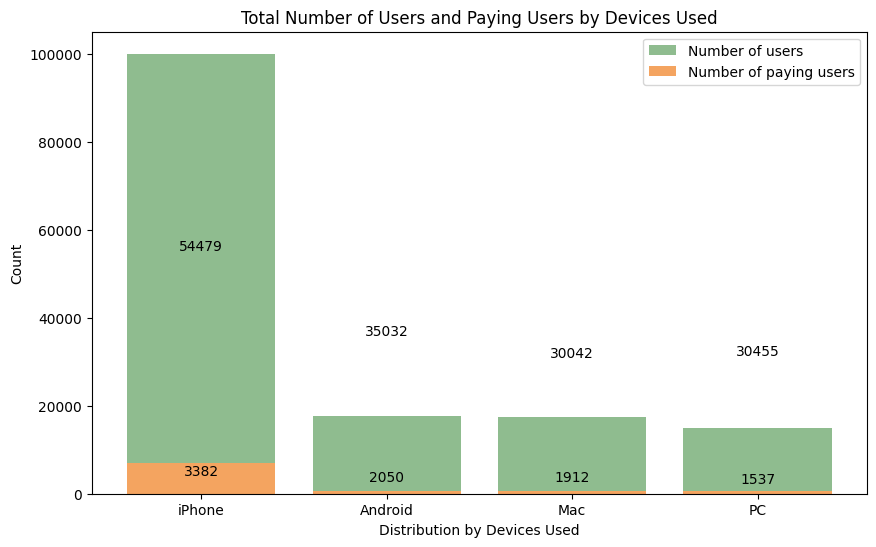

In [25]:
# Building a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Defining the width of the bars
bar_width = 0.8

# Building the users_count bar
ax.bar(sorted_table_2.index, 
       sorted_table['users_count'], 
       color='darkseagreen', 
       label='Number of users')

# Building the payers_count bar inside users_count
ax.bar(sorted_table_2.index, 
       sorted_table['payers_count'], 
       color='sandybrown', 
       label='Number of paying users', 
       width=bar_width)

# Setting up the legend display
ax.legend()

# Adding annotations to the bars
for i, v in enumerate(sorted_table_2['users_count']):
    ax.text(i, v + 200, str(v), ha='center', va='bottom')

for i, v in enumerate(sorted_table_2['payers_count']):
    ax.text(i, v + 100, str(v), ha='center', va='bottom')

# Setting axes labels and title
ax.set_xlabel('Distribution by Devices Used')
ax.set_ylabel('Count')
ax.set_title('Total Number of Users and Paying Users by Devices Used')

# Displaying the chart
plt.show()

Clients use four types of devices - iPhone, Android, Mac, and PC. The highest number of both overall users and paying users specifically use iPhone.

### Channels of User Acquisition

Let's analyze the advertising sources of user acquisition and determine which channels brought the most of paying users.

In [26]:
# Determining the number of users by acquisition channels
users_by_channel = profiles.pivot_table(
    index=['channel'],
    values=['user_id'],
    aggfunc='count'
).rename(columns={'user_id': 'users_count'})

# Determining the number of paying users by acquisition channels
users_by_channel_payers = profiles[profiles['payer'] == True].pivot_table(
    index=['channel'],
    values=['user_id'],
    aggfunc='count'
).rename(columns={'user_id': 'payers_count'})

# Merging the two tables
merged_table_3 = users_by_channel.merge(users_by_channel_payers, on='channel', how='left')
sorted_table_3 = merged_table_3.sort_values(by='payers_count', ascending=False)

# Adding a column for the share of paying users by acquisition channels
sorted_table_3['payers_share'] = sorted_table_3['payers_count'] / sorted_table_3['users_count'] * 100
sorted_table_3['payers_share'] = sorted_table_3['payers_share'].round(2)
sorted_table_3

# Defining a function to highlight a column
def highlight_column(s):
    return ['background-color: darkseagreen' if col == 'payers_count' else '' for col in s.index]

# Applying the style to the dataframe
styled_table = sorted_table_3.style.apply(highlight_column, axis=1)

# Displaying the styled table
styled_table

,users_count,payers_count,payers_share
channel,,,
FaceBoom,29144,3557,12.200000
TipTop,19561,1878,9.600000
organic,56439,1160,2.060000
WahooNetBanner,8553,453,5.300000
AdNonSense,3880,440,11.340000
RocketSuperAds,4448,352,7.910000
LeapBob,8553,262,3.060000
OppleCreativeMedia,8605,233,2.710000
lambdaMediaAds,2149,225,10.470000


Let's build a table reflecting the number of users and the share of payers for each acquisition channel.

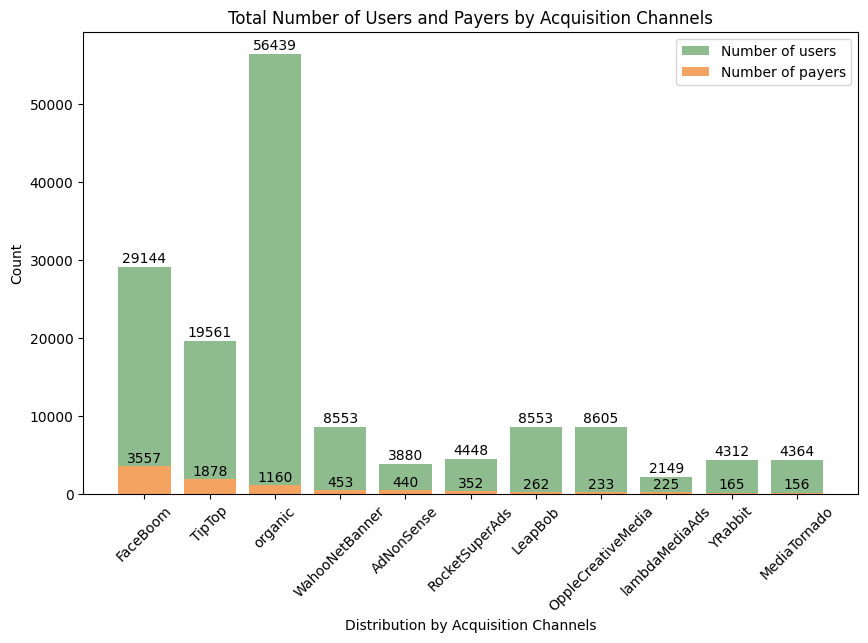

In [27]:
# Building a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Defining the width of the bars
bar_width = 0.8

# Plotting the users_count bar
ax.bar(sorted_table_3.index, 
       sorted_table_3['users_count'], 
       color='darkseagreen', 
       label='Number of users')

# Plotting the payers_count bar within users_count
ax.bar(sorted_table_3.index, 
       sorted_table_3['payers_count'], 
       color='sandybrown', 
       label='Number of payers', 
       width=bar_width)

# Setting up the legend display
ax.legend()

# Adding annotations to the bars
for i, v in enumerate(sorted_table_3['users_count']):
    ax.text(i, v + 200, str(v), ha='center', va='bottom')

for i, v in enumerate(sorted_table_3['payers_count']):
    ax.text(i, v + 100, str(v), ha='center', va='bottom')

# Setting up axes and title
ax.set_xlabel('Distribution by Acquisition Channels')
ax.set_ylabel('Count')
ax.set_title('Total Number of Users and Payers by Acquisition Channels')

# Rotating x-axis labels
plt.xticks(rotation=45)

# Displaying the chart
plt.show()

In contrast to the distribution by countries and devices, there is no linear relationship between the total number of users and the number of paying users in the distribution by acquisition channels. For example, the largest number of users overall came through organic channels, but among paying users, organic users only rank third. The second highest in terms of total users came through FaceBoom, yet this channel attracts the largest paying audience to the product.

It can be concluded that the period analyzed for user acquisition is from May 1, 2019, to October 27, 2019. Users are unevenly distributed across four countries: the USA, UK, France, and Germany. The largest number of both overall users and paying users comes from the USA. The distribution of users based on the type of device used is also uneven, with the overwhelming majority of both overall users and paying users using iPhones. Among other devices are Android, Mac, and PC. When analyzing user distribution by acquisition channels, there is no linear relationship between the number of acquired users and paying users: the largest number of overall users came to the app organically (ranking 3rd in terms of paying users), while the largest number of paying users was acquired through FaceBoom (ranking 2nd in terms of all acquired users).

## Marketing

### Total Marketing Expenses

In [28]:
# Displaying the total marketing expenses
(ad_costs['costs'].sum()).round(2)

105497.3

### Distribution of Expenses Across Advertising Sources

In [29]:
# Determining expenses broken down by user acquisition channels
costs_by_channel = ad_costs.pivot_table(
    index = ['channel'], 
    values = ['costs'], 
    aggfunc ='sum')
costs_by_channel = costs_by_channel.sort_values(by = 'costs', ascending = False)
costs_by_channel

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


### Dynamics of Expenditure Changes over Time by Weeks for Each Source

In [30]:
# Adding a week number column to the ad_costs dataframe
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']) 
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week

# Creating a table with data on total advertising costs broken down by acquisition channels and weeks
ad_costs_by_week = ad_costs.groupby(['week', 'channel'])['costs'].sum().reset_index()  
ad_costs_by_week.round(2).head(5)

,week,channel,costs
0,18,AdNonSense,211.05
1,18,FaceBoom,535.70
2,18,LeapBob,16.80
3,18,MediaTornado,38.64
4,18,OppleCreativeMedia,24.00


Let's visualize the data from the table above:

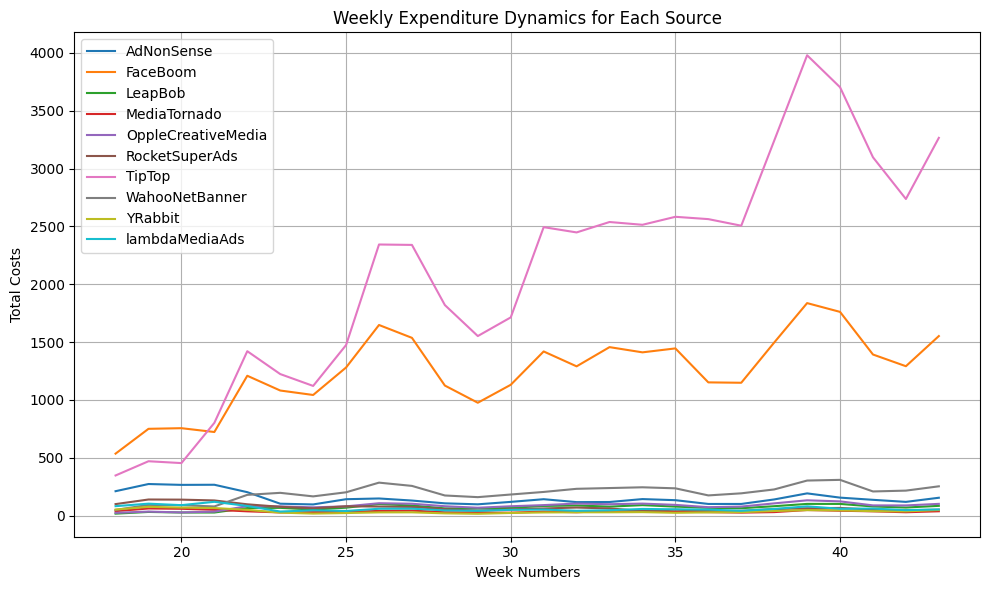

In [31]:
# Plotting the graph
plt.figure(figsize=(10, 6))

# Grouping data by channels and plotting a line graph for each channel
for channel, data in ad_costs_by_week.groupby('channel'):
    plt.plot(data['week'], data['costs'], label=channel)

# Adding legend and axis labels
plt.legend()
plt.xlabel('Week Numbers')
plt.ylabel('Total Costs')
plt.title('Weekly Expenditure Dynamics for Each Source')

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()

Two sources stand out sharply with high marketing expenditures - TipTop and FaceBoom. Moreover, the diagram shows that expenditures on these acquisition channels not only exceed those of all other channels but also demonstrate a tendency of continuous growth.

### Investment Dynamics over Time by Month for Each Source

In [32]:
# Adding a column to the ad_costs dataframe with the month number
ad_costs['month'] = ad_costs['dt'].dt.month

# Creating a table with data on the sum of advertising costs grouped by acquisition channels and months
ad_costs_by_month = ad_costs.groupby(['month', 'channel'])['costs'].sum().reset_index()  
ad_costs_by_month.round(2).head(5)

,month,channel,costs
0,5,AdNonSense,1169.70
1,5,FaceBoom,3524.40
2,5,LeapBob,140.28
3,5,MediaTornado,238.56
4,5,OppleCreativeMedia,169.75


Let's visualize the data from the table above:

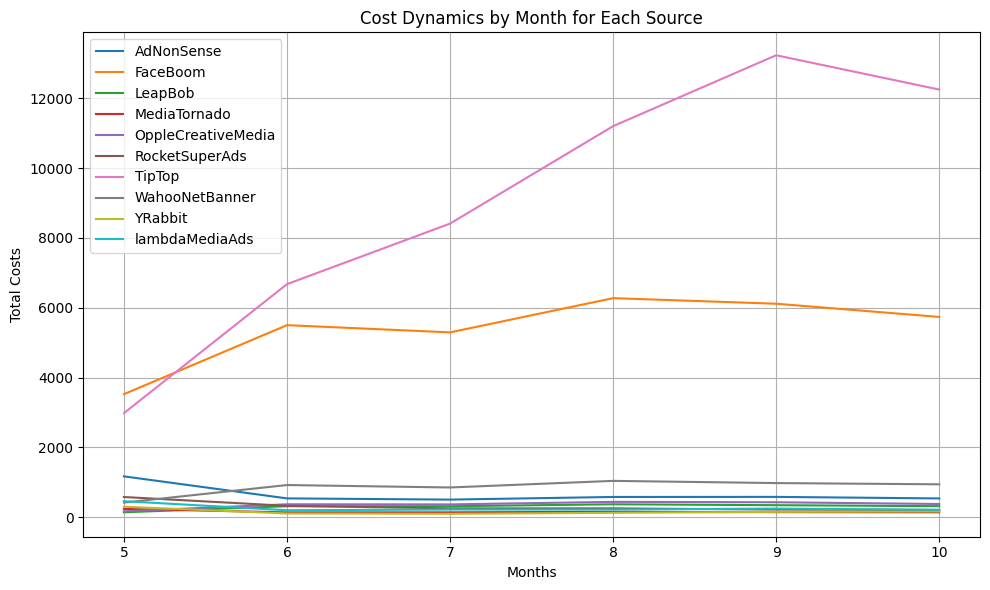

In [33]:
# Plotting
plt.figure(figsize=(10, 6))

# Grouping data by channels and plotting a line graph for each channel
for channel, data in ad_costs_by_month.groupby('channel'):
    plt.plot(data['month'], data['costs'], label=channel)

# Adding legend and axis labels
plt.legend()
plt.xlabel('Months')
plt.ylabel('Total Costs')
plt.title('Cost Dynamics by Month for Each Source')

# Displaying the plot
plt.grid(True)
plt.tight_layout()
plt.show()

On this graph, as well as on the one reflecting the breakdown by weeks, it is evident that two acquisition channels - TipTop and FaceBoom - require significantly higher investments compared to others. However, there are distinct trends between them: FaceBoom shows a slight increase in expenses (from June onwards, costs fluctuate around a consistent level), whereas TipTop exhibits a sharp growth, reaching a colossal peak in September.

### Average Cost of Acquisition (CAC) per User from Each Source

In [34]:
# Forming a pivot table with information on total acquisition costs by channel
accost_by_channel = profiles.pivot_table(index=['channel'], values=['acquisition_cost'], aggfunc='sum')
accost_by_channel = accost_by_channel.rename(columns={'acquisition_cost': 'acquisition_cost_agg'})

# Determining the number of users by acquisition channels
users_by_channel = profiles.pivot_table(index=['channel'], values=['user_id'], aggfunc='count')
users_by_channel = users_by_channel.rename(columns={'user_id': 'users_count'})

# Merging the two tables
accost_by_channel = accost_by_channel.merge(users_by_channel, on=['channel'], how='left')

# Calculating the mean Cost of Acquisition (CAC) per user for each channel
accost_by_channel['mean_cac'] = accost_by_channel['acquisition_cost_agg'] / accost_by_channel['users_count']

# Sorting the data by mean CAC values
accost_by_channel = accost_by_channel.sort_values(by='mean_cac', ascending=False)
accost_by_channel

# Defining a function to highlight the column
def highlight_column(s):
    return ['background-color: darkseagreen' if col == 'mean_cac' else '' for col in s.index]

# Applying styling and formatting to the dataframe
styled_table = accost_by_channel.style.apply(highlight_column, axis=1).format({
    'acquisition_cost_agg': '{:.2f}',
    'mean_cac': '{:.2f}'
})

# Displaying the styled table
styled_table

,acquisition_cost_agg,users_count,mean_cac
channel,,,
TipTop,54751.30,19561,2.80
FaceBoom,32445.60,29144,1.11
AdNonSense,3911.25,3880,1.01
lambdaMediaAds,1557.60,2149,0.72
WahooNetBanner,5151.00,8553,0.60
RocketSuperAds,1833.00,4448,0.41
OppleCreativeMedia,2151.25,8605,0.25
YRabbit,944.22,4312,0.22
MediaTornado,954.48,4364,0.22


The average cost of acquiring one user through TipTop exceeds that of FaceBoom by more than twice.

Based on the evaluation of marketing data, it can be concluded that with total expenditures nearly reaching 105,500, over half of these costs — around 55,000 — are attributed to TipTop. However, despite this significant investment, TipTop only attracts approximately 13% of users (including organically acquired users) or about 21% (excluding them). In contrast, FaceBoom attracts about 31% of users (excluding organically acquired), with marketing expenses for this channel not exceeding 30%.

All analyzed metrics — weekly and monthly spending dynamics, as well as CAC — indicate that marketing expenses for the TipTop channel are exceedingly high and show a tendency for rapid growth, without clear evidence of the effectiveness of such significant expenditures on this acquisition channel.

## Return on Advertising Spend 

### Advertising ROI Analysis using LTV and ROI Charts, as well as LTV, CAC, and ROI Dynamics Charts

Setting the moment and horizon of data analysis:

In [35]:
observation_date = datetime(2019, 11, 1).date()  # moment of data analysis
horizon_days = 14  # horizon of data analysis

Since users who come to the app organically generate zero marketing costs, we will exclude them from further analysis:

In [36]:
profiles_2 = profiles.loc[profiles['channel'] != 'organic']
visits_2 = visits.loc[visits['channel'] != 'organic']

Let's calculate and visualize LTV and ROI by calling the functions `get_ltv()` and `plot_ltv_roi()`.

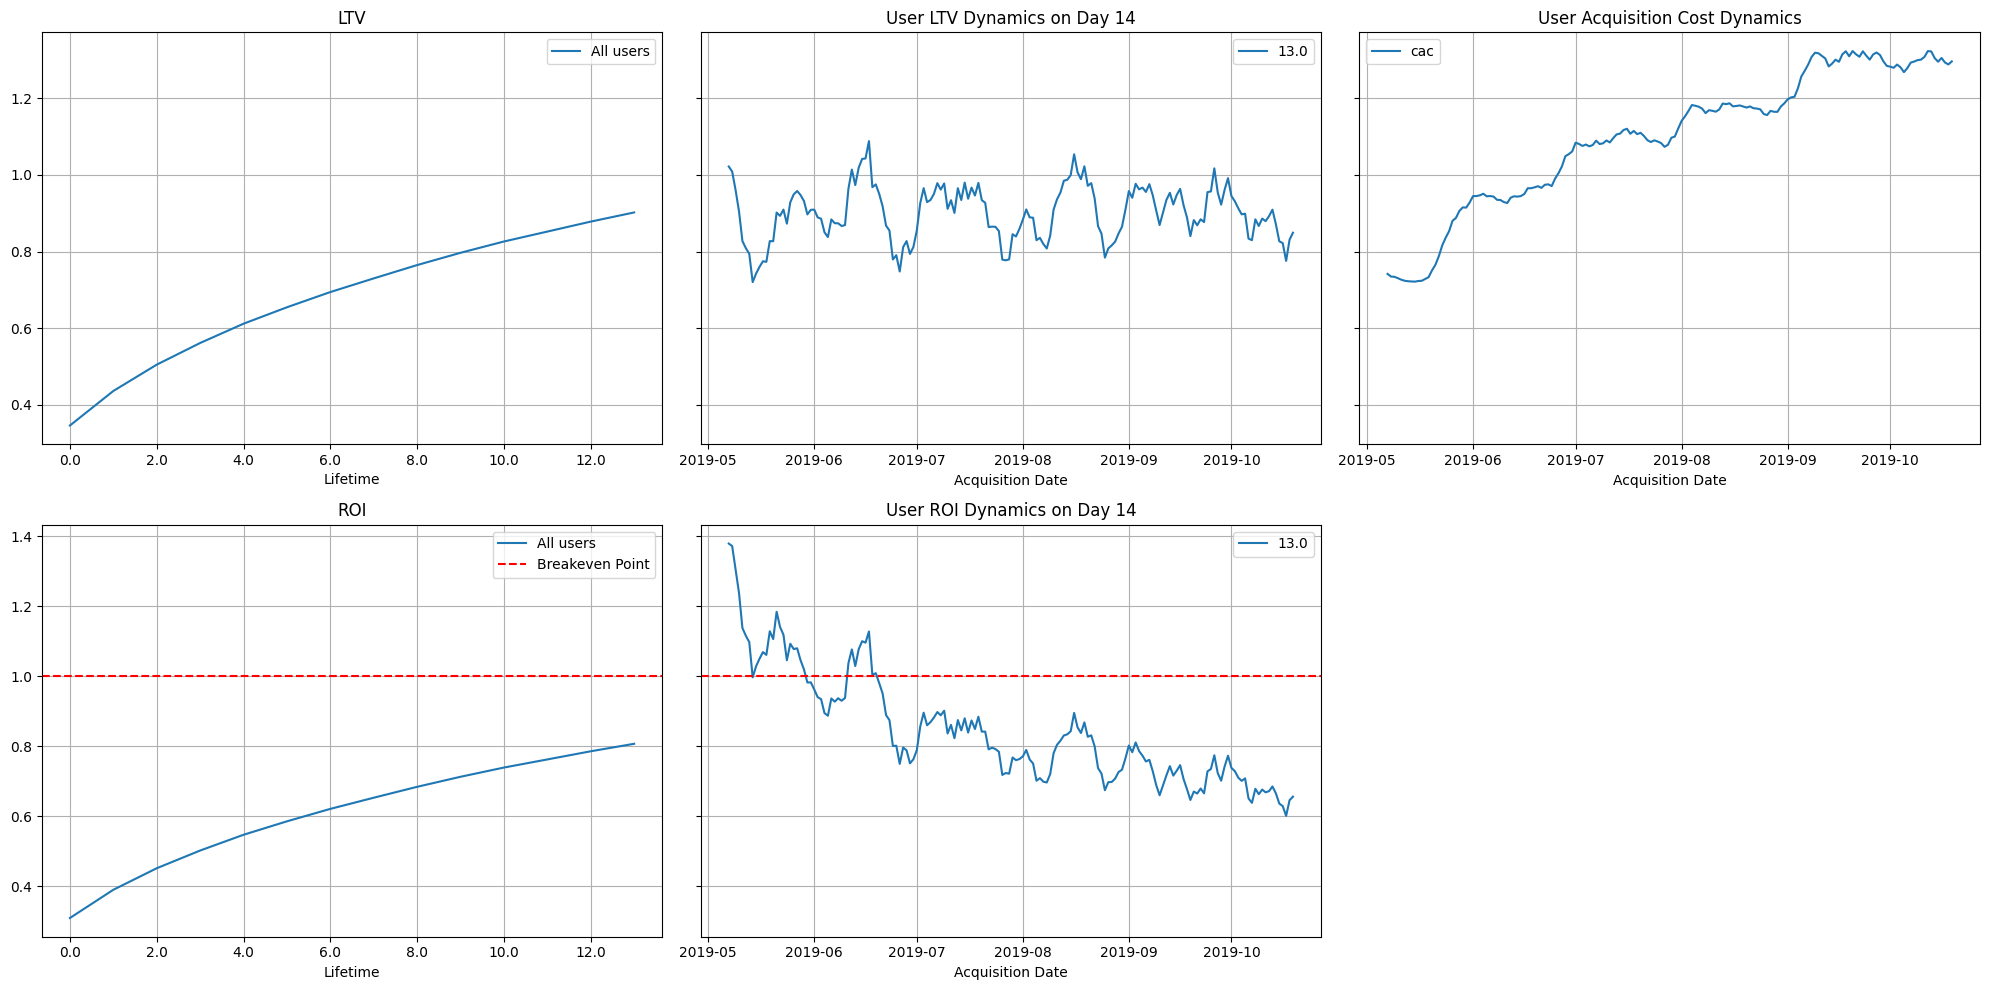

In [37]:
# Calculating LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days
)

# Plotting graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Overall, monthly fluctuations in LTV are evident, yet it steadily increases over time. ROI also shows growth, but at a significantly slower rate compared to LTV. As of the observation date, advertising costs have not yet been recouped because ROI has not reached breakeven. This is attributed to a sharp increase in user acquisition costs starting from June 2019, which slowed in subsequent months but maintained a trend of stable growth. The ROI dynamics chart for the 14th day indicate that users acquired since June 2019 are not profitable, likely due to high marketing expenses incurred to acquire them.

### Conversion and User Retention at a Specific Moment and over Time

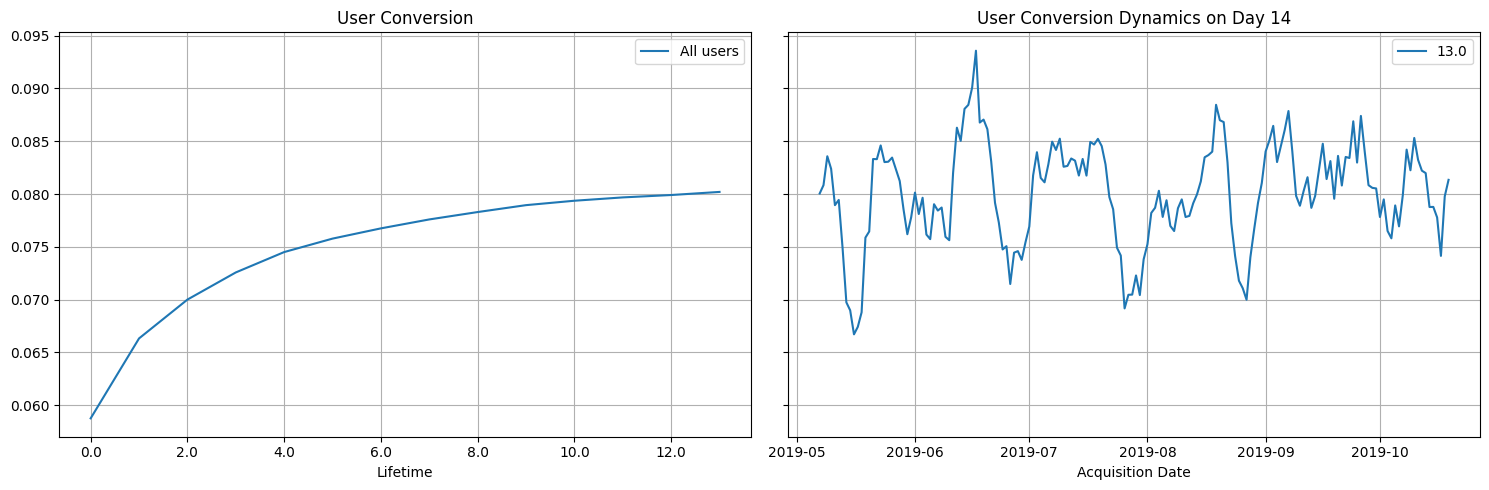

In [38]:
# Conversion visualization

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

The conversion rate continues to rise, mirroring the trend in LTV dynamics. 

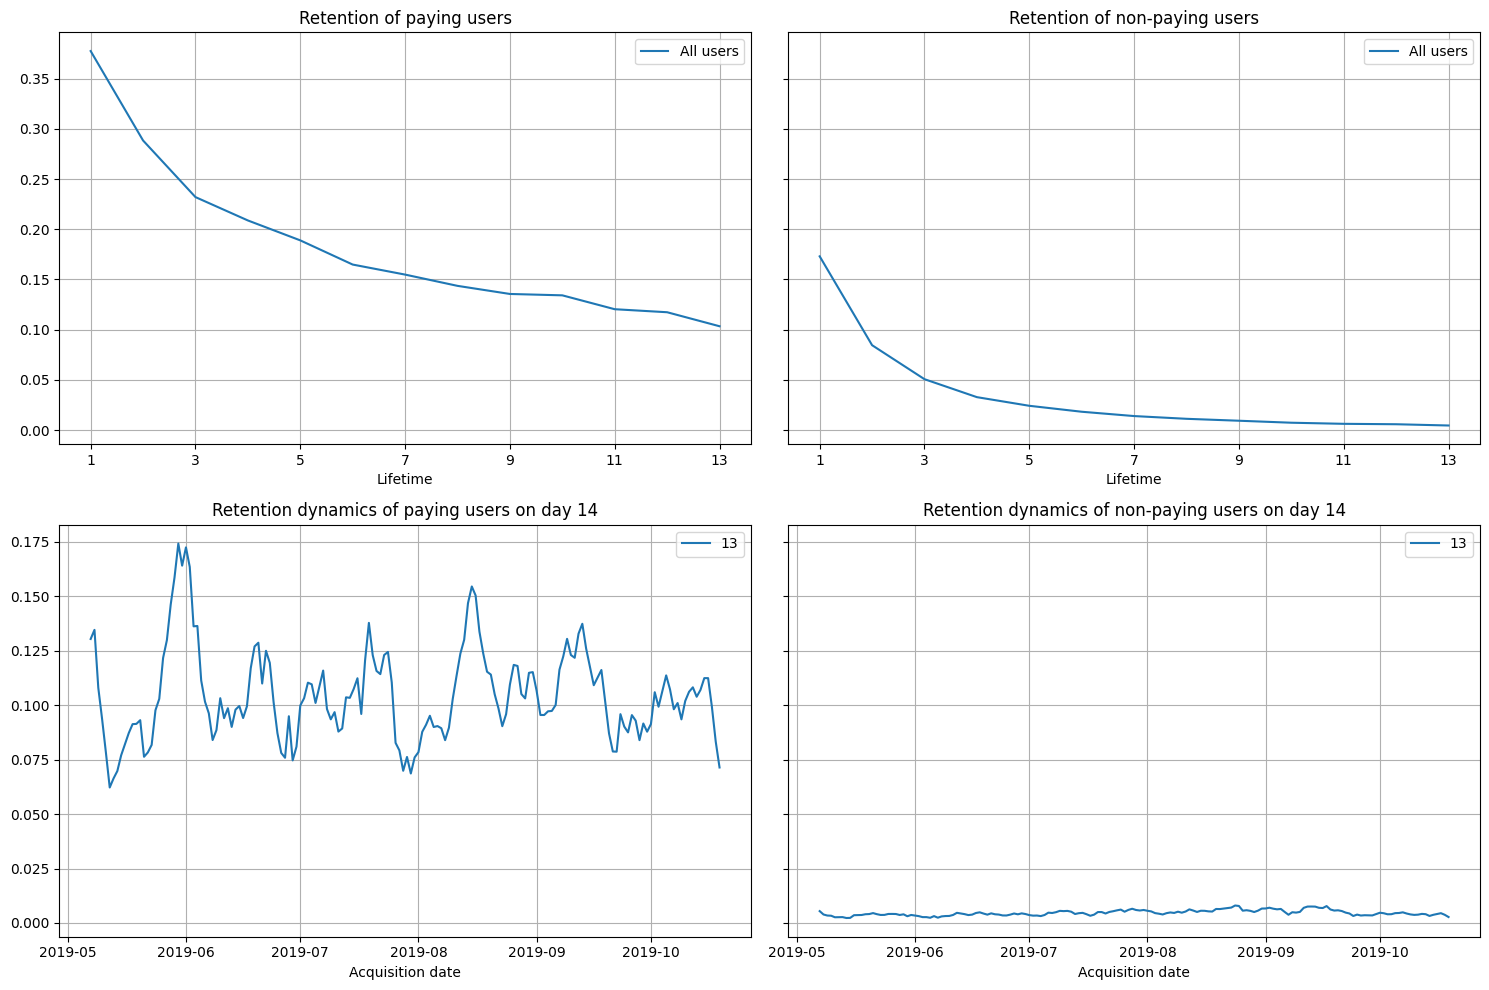

In [39]:
# Retention visualization 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days) 

User retention steadily declines over time, with paying users consistently showing better retention rates compared to non-paying users. However, the decrease in retention is quite pronounced for both groups. There is no significant variation in user retention decline based on their acquisition time: it's worth noting that paying users acquired earlier in the study period had slightly higher retention rates compared to those acquired later.

### Return on Investment (ROI) of Advertising by Devices

Visualizing the LTV and ROI graphs, along with the dynamics of LTV, CAC, and ROI.

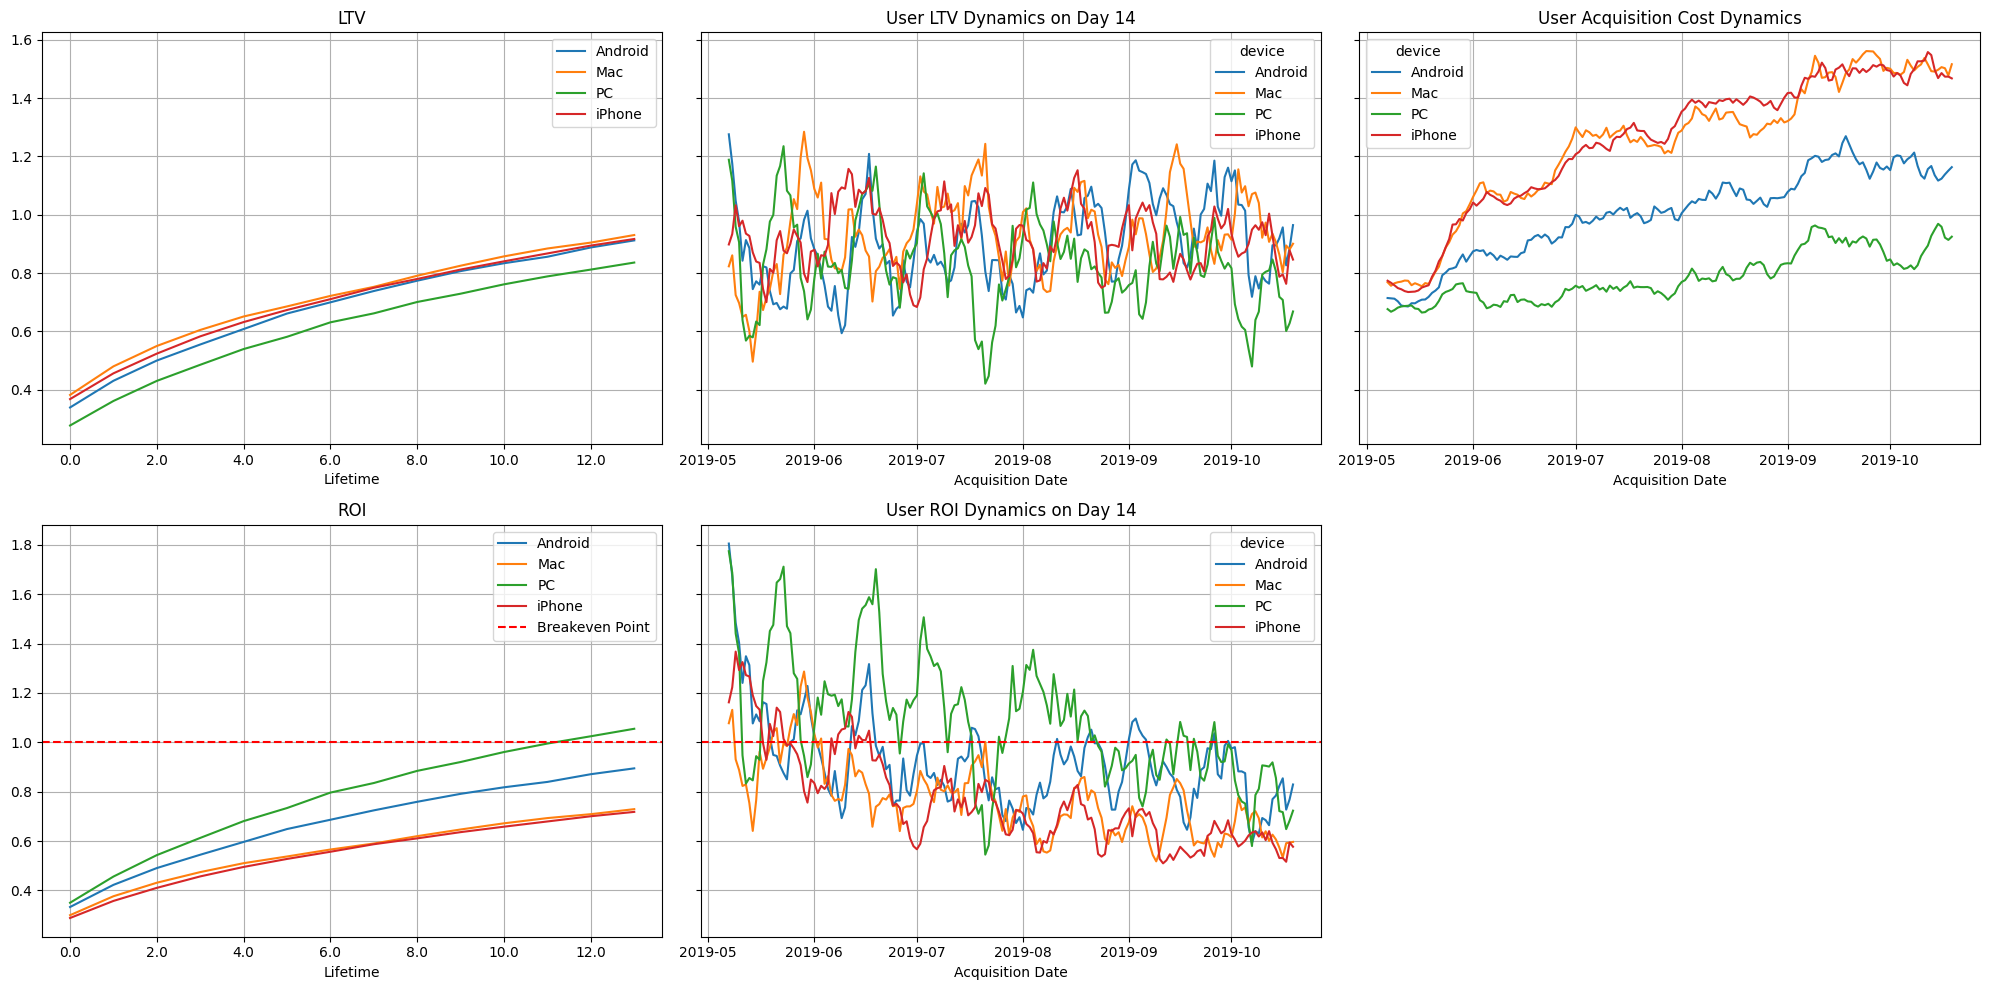

In [40]:
# Calculating LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['device']
)

# Plotting graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Despite Mac, iPhone, and Android users generating more revenue, their return on investment (ROI) does not reach profitability levels compared to PC users. This is due to the sharp increase in user acquisition costs for Mac, iPhone, and Android users. The 'User ROI Dynamics' table indicates that user acquisition for Mac, iPhone, and Android users ceased to be profitable as early as July. However, the ROI trend for PC users is also negative, suggesting that without intervention, acquiring these users will also cease to be profitable in the near future (assuming current trends in CAC growth persist).

### Return on Investment (ROI) of Advertising by Countries

Visualizing the LTV and ROI graphs, along with the dynamics of LTV, CAC, and ROI.

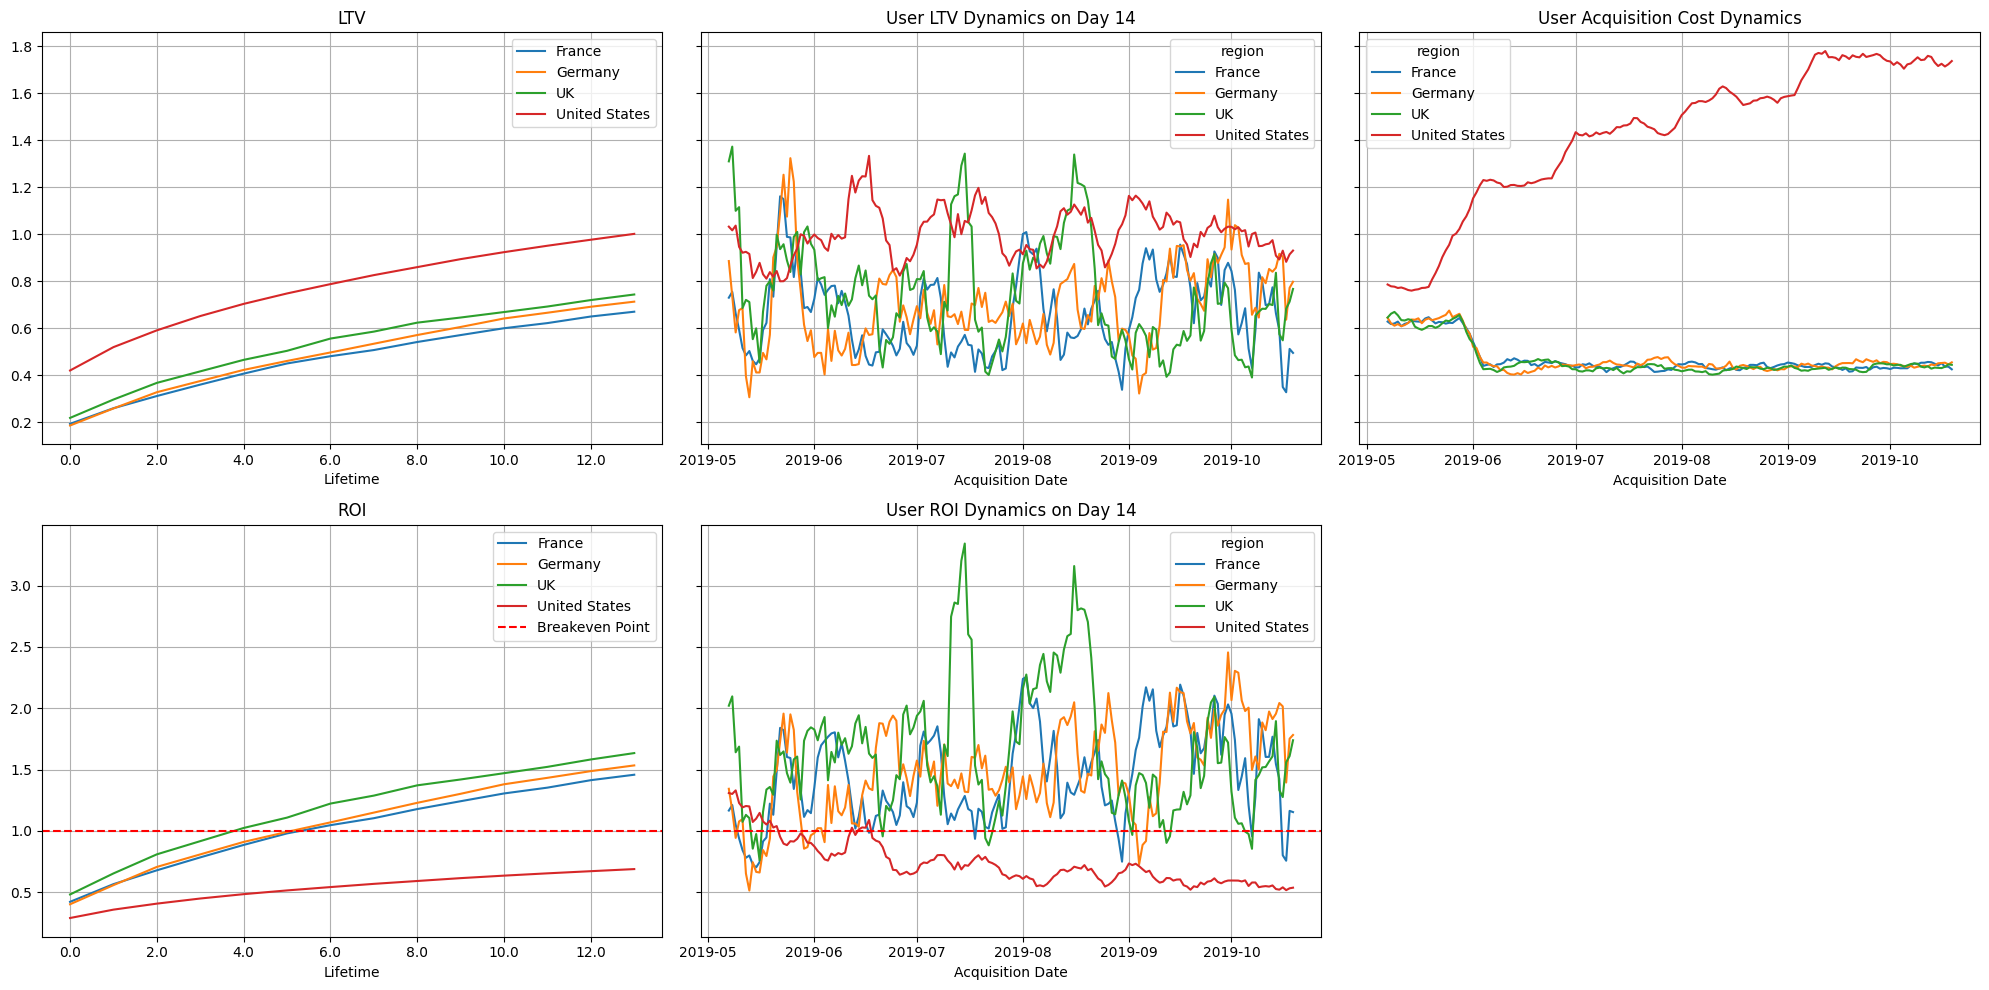

In [41]:
# Calculating LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['region']
)

# Plotting graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

When broken down by countries, the situation mirrors that of device breakdown: users from the USA generate the highest revenue. However, due to the incredibly high cost of acquiring this customer segment in the US market, profitability remains elusive. In the trend analysis, users from the USA ceased to be profitable around July. Similar patterns can be observed between users of iPhones and Macs and those from the USA, where these devices are predominantly used.

### Return on Investment (ROI) of Advertising by Channels of User Acquisition

Visualizing the LTV and ROI graphs, along with the dynamics of LTV, CAC, and ROI.

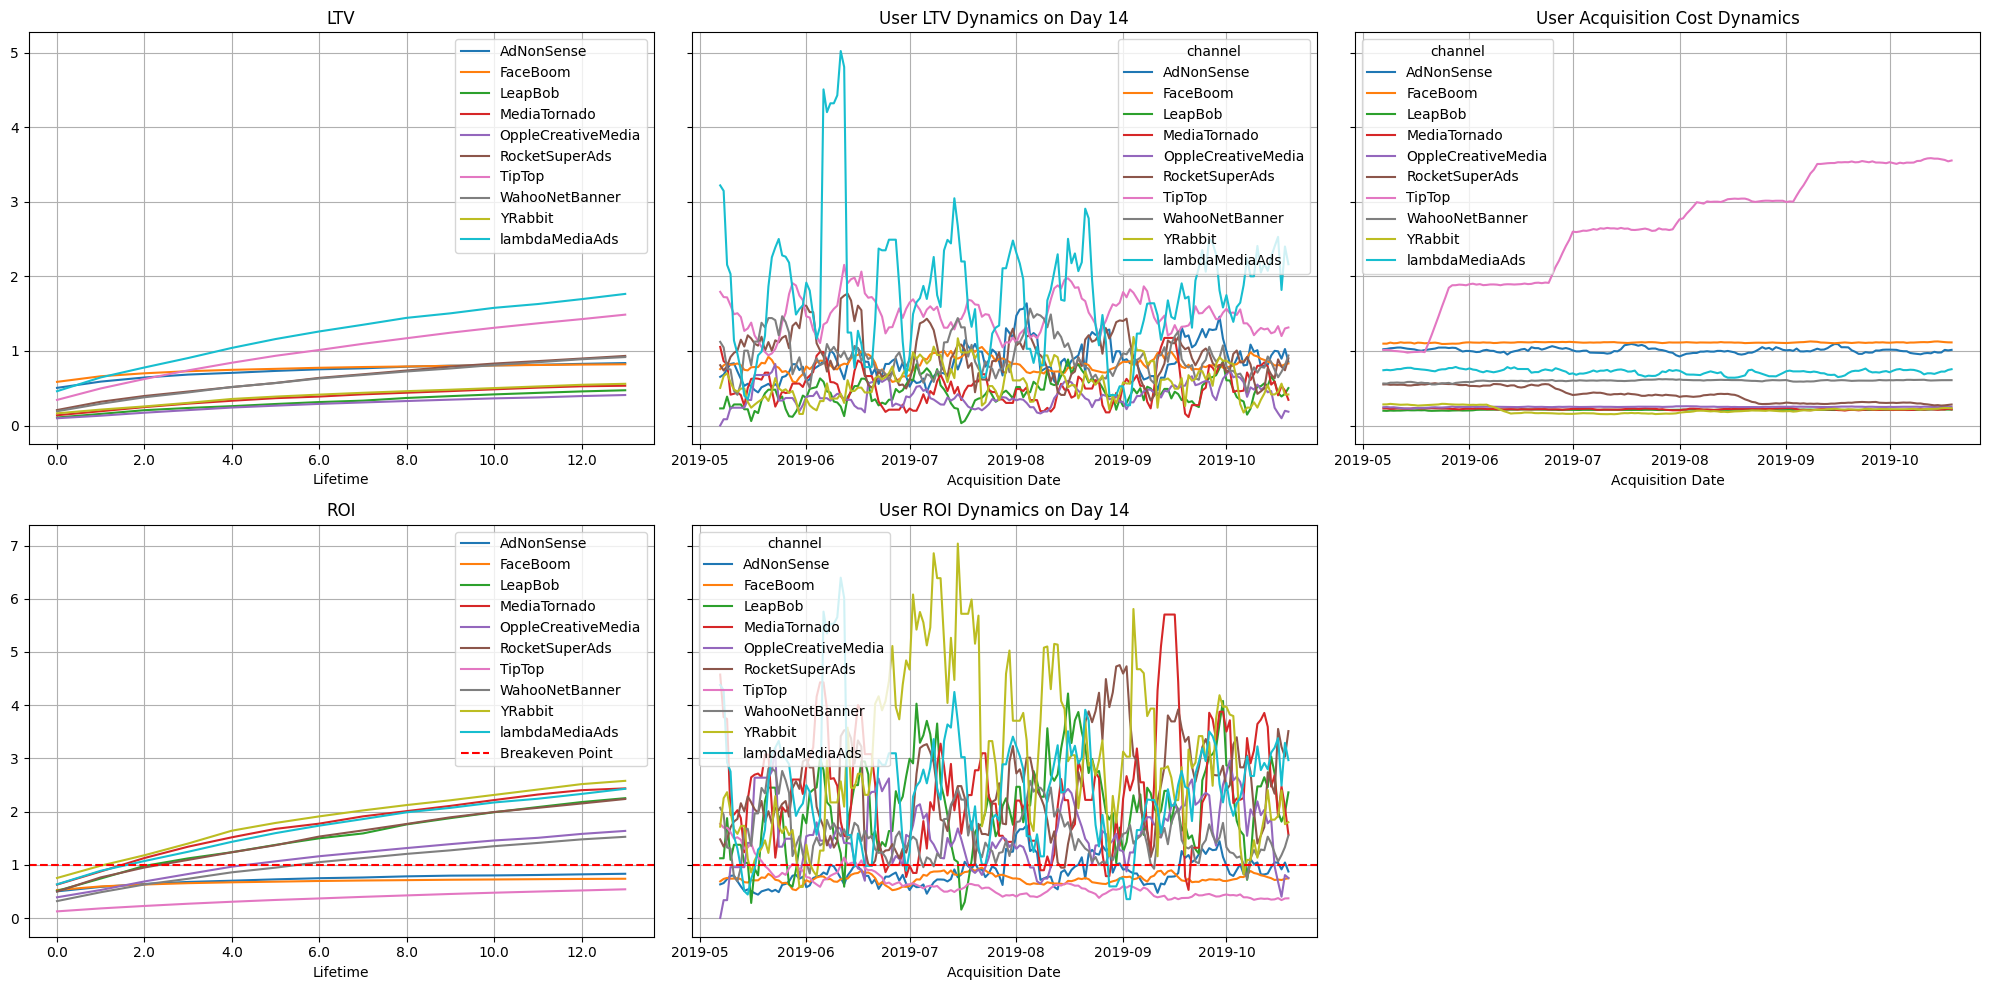

In [42]:
# Calculating LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['channel']
)

# Plotting graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Based on the information presented in the charts, lambdaMediaAds stands out as a successful user acquisition channel. Despite relatively low acquisition costs, this channel attracts users who generate significant revenue, resulting in a high level of profitability. Similarly, YRabbit shows high profitability with low costs. In contrast, the most expensive acquisition channels, TipTop and FaceBoom (which have the highest CAC values), do not achieve profitability with the users they attract, as evidenced by both the ROI chart and the ROI dynamics chart.

### Conversion and User Retention by Acquisition Channels, Countries, and Devices

**Acquisition channels:**

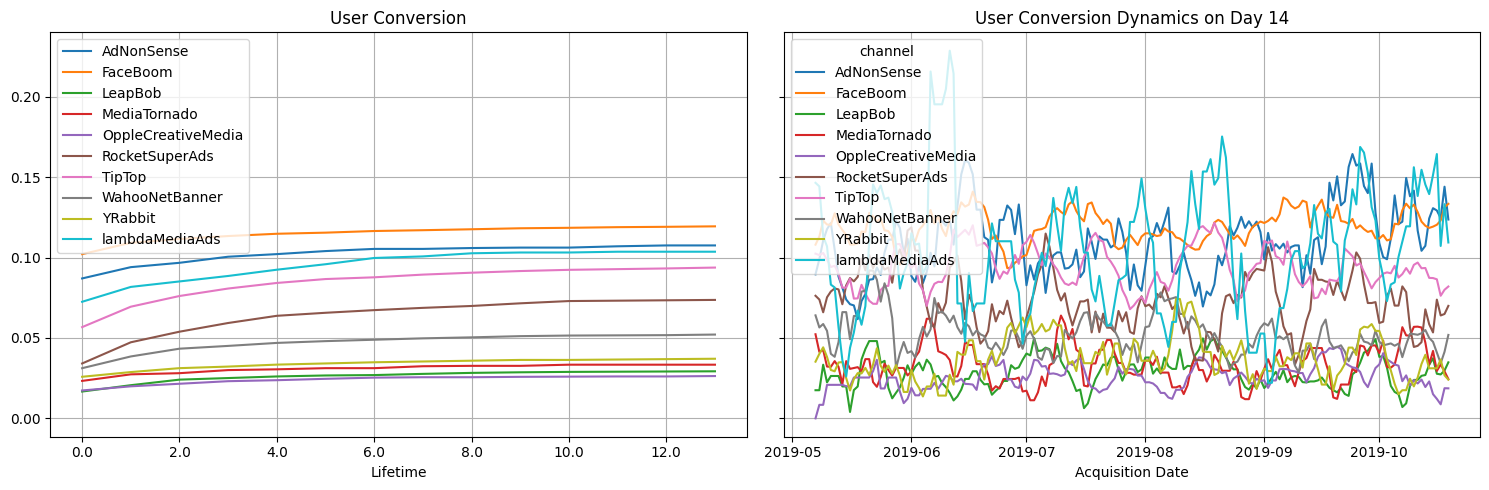

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

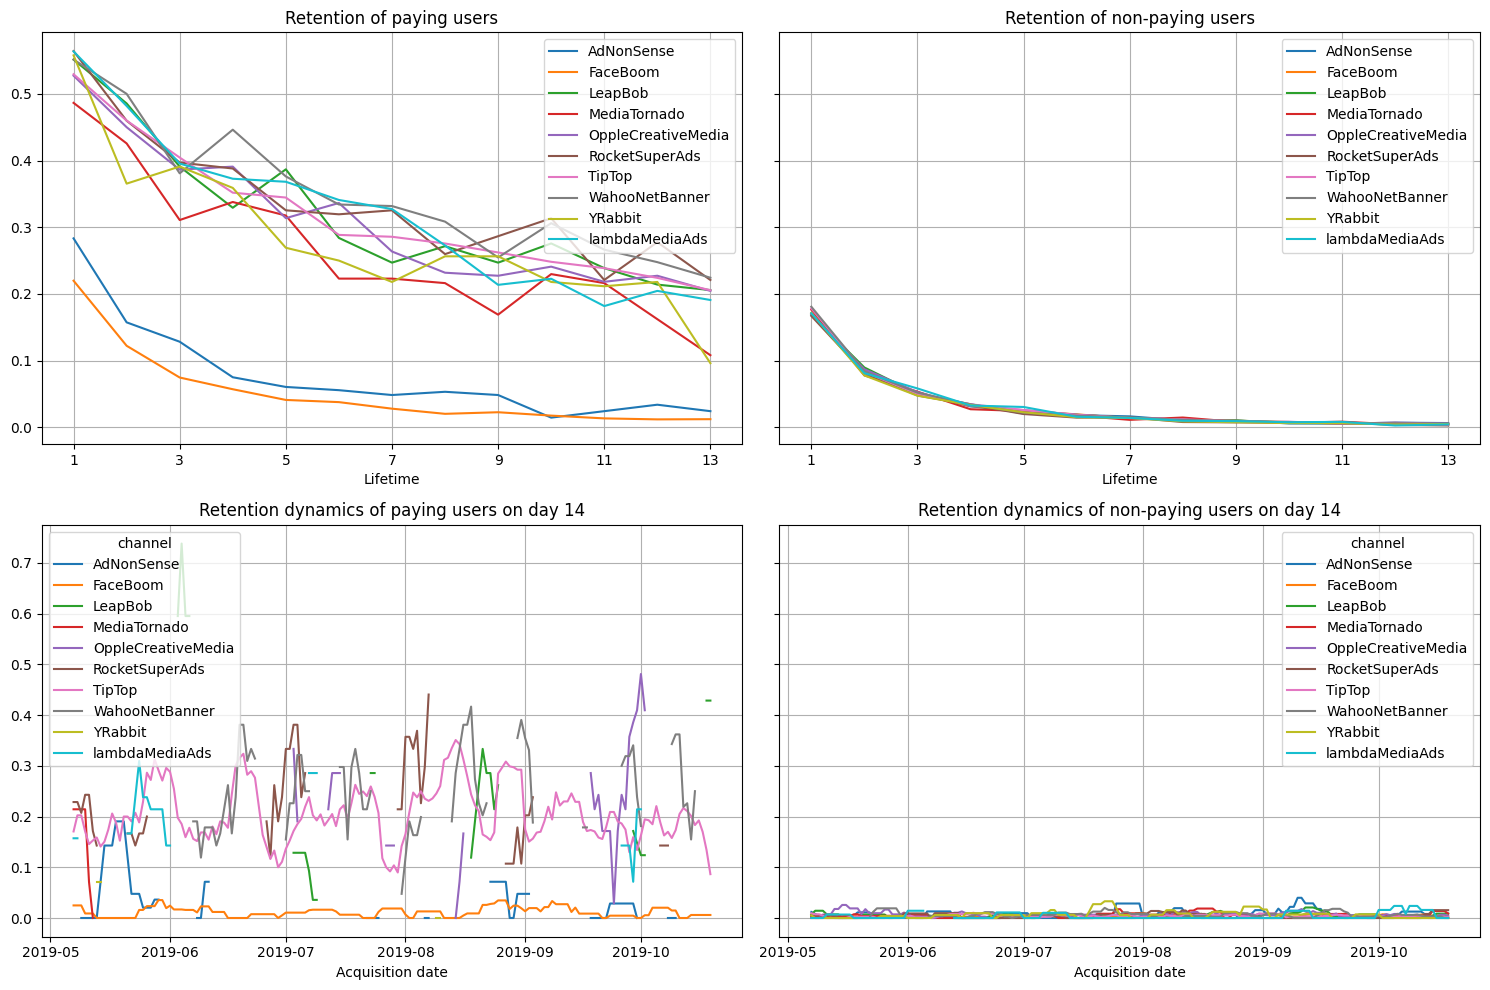

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days, dimensions = ['channel'])

plot_retention(retention_grouped, retention_history, horizon_days) 

From the graphs, it is evident that FaceBoom and AdNoneSense channels yield the highest user conversion rates, but they exhibit the lowest user retention levels.

**Countries:**

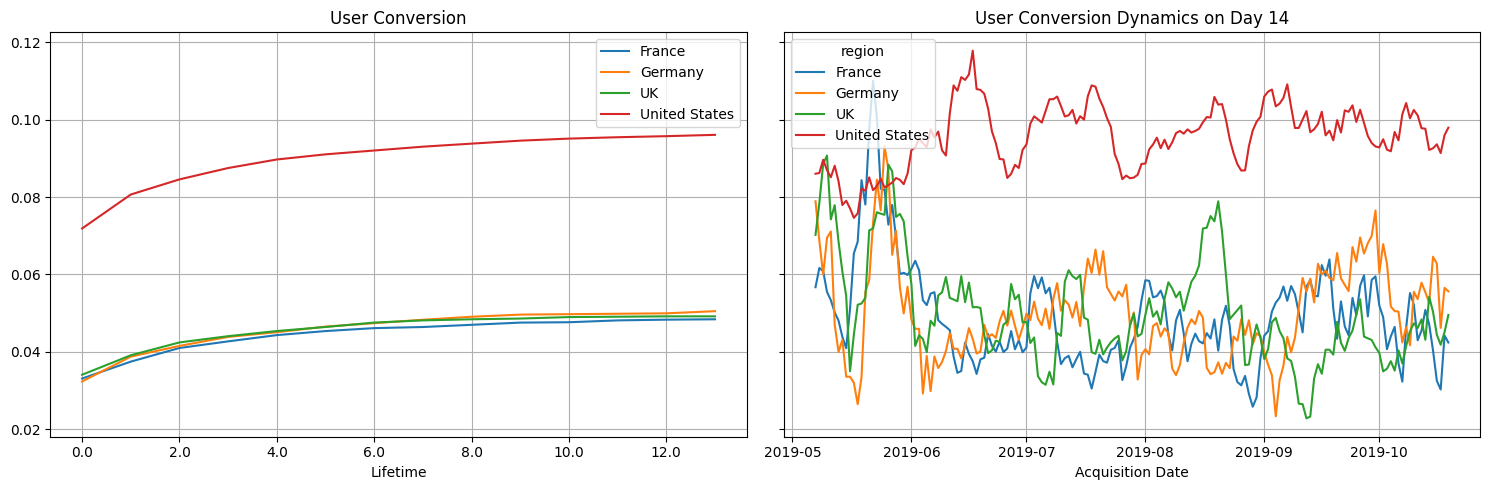

In [45]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['region'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

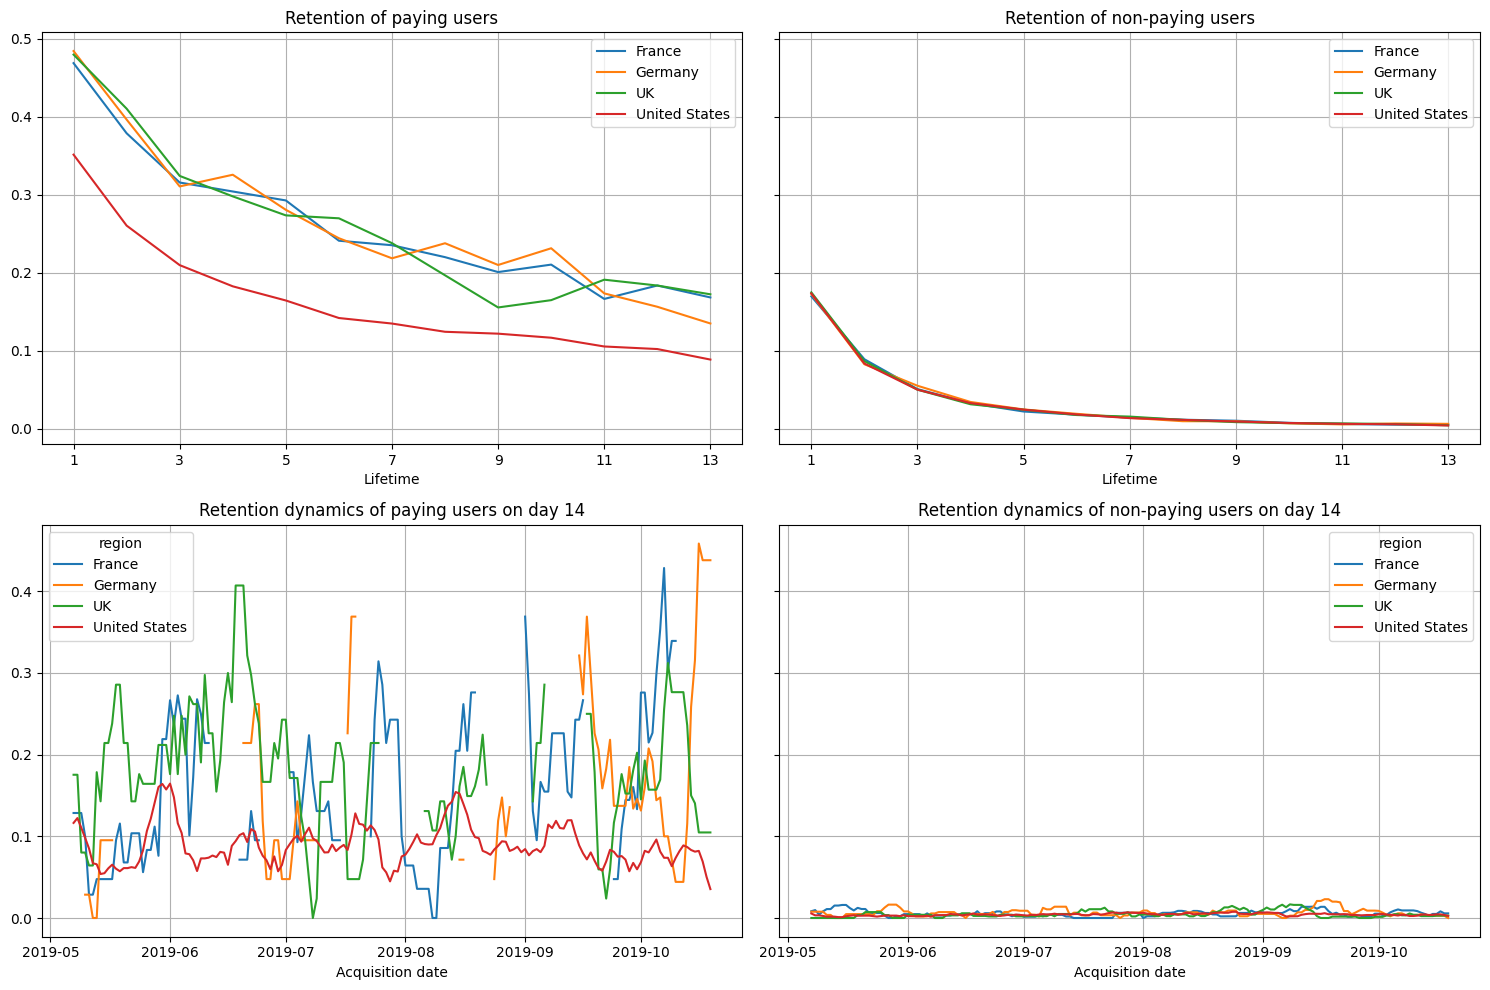

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days, dimensions = ['region'])

plot_retention(retention_grouped, retention_history, horizon_days) 

Similarly to the situation with acquisition channels, users from the USA show the highest conversion rates but the poorest retention.

**Devices:**

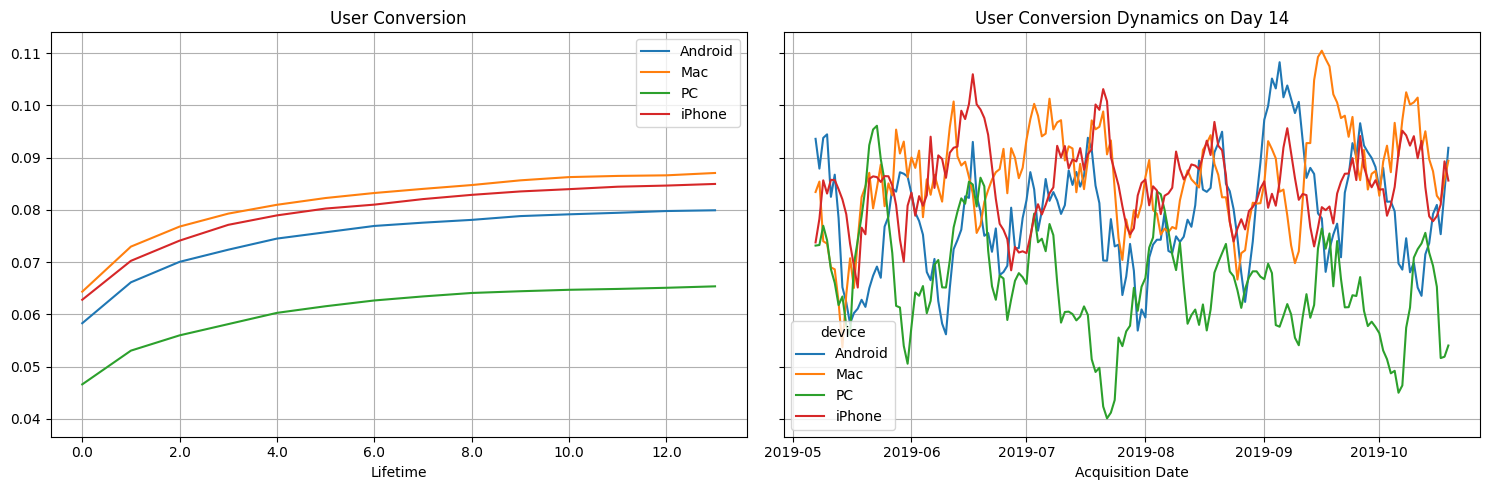

In [47]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_2, orders, observation_date, horizon_days, dimensions = ['device'])

plot_conversion(conversion_grouped, conversion_history, horizon_days)

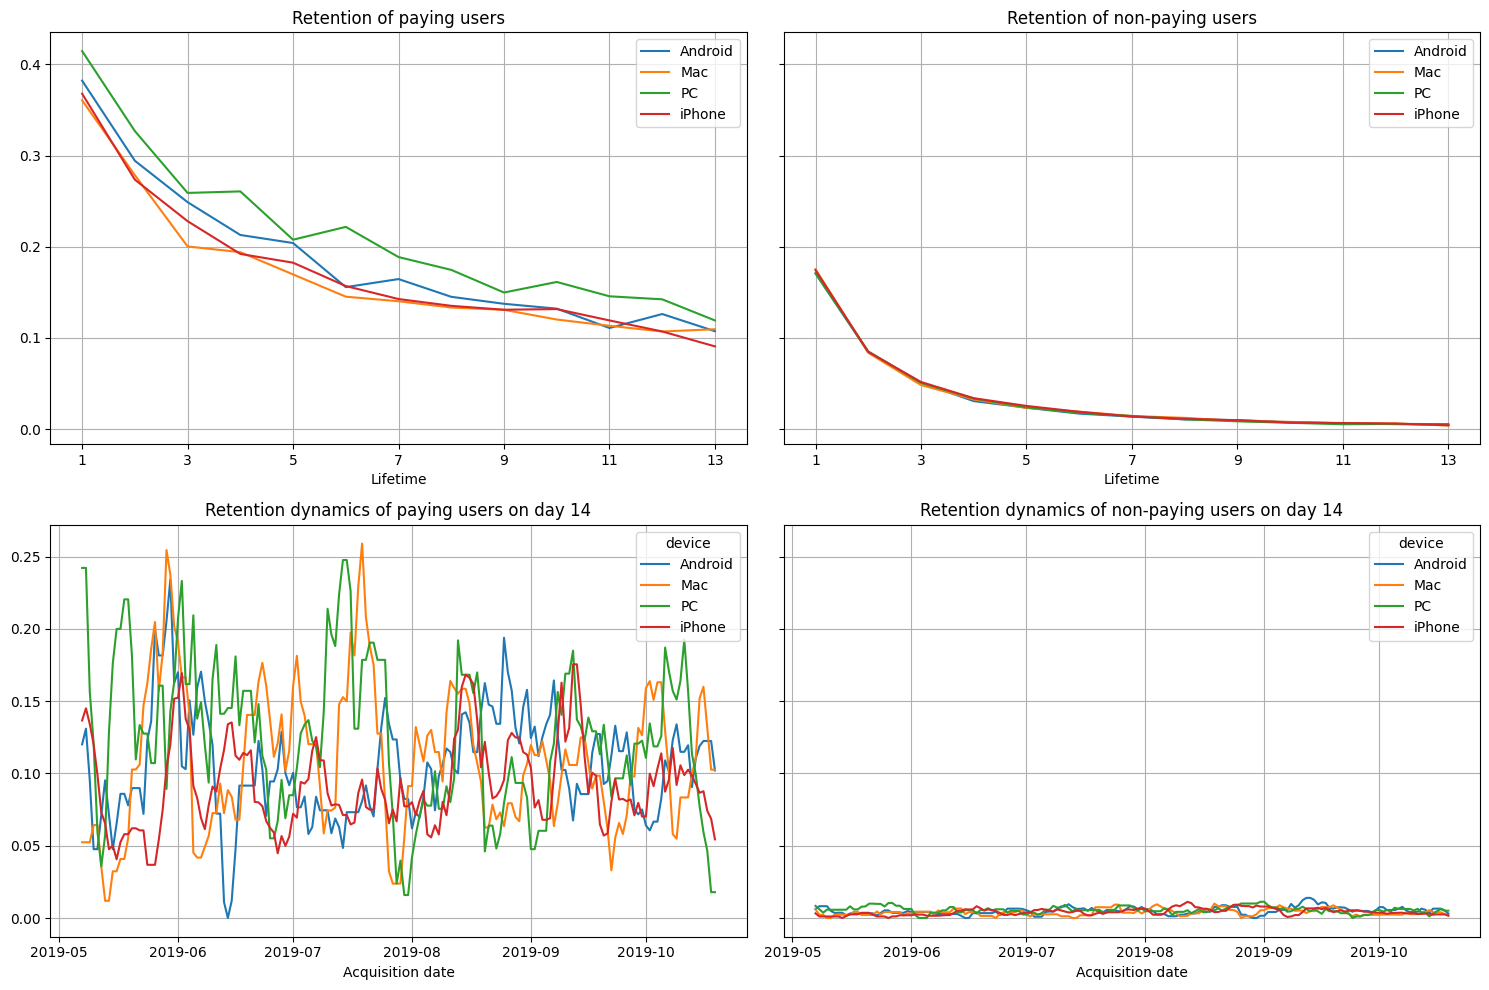

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_2, visits_2, observation_date, horizon_days, dimensions = ['device'])

plot_retention(retention_grouped, retention_history, horizon_days) 

PC users show the worst conversion rate but the highest retention.

Overall, it can be said that starting from July, advertising aimed at user acquisition has generally ceased to be profitable. The high cost of advertising placements on TipTop and FaceBoom has had a negative impact on profitability. Additionally, user acquisition targeting iPhone (the vast majority) and Mac devices, as well as users from the USA (also the majority), has not proven profitable. There are channels, such as FaceBoom and AdNonSense, that achieve high user conversion rates but also exhibit the lowest retention rates.

## Analysis Results

After data studying it can be said that the initial dataset is comprehensive, containing no missing values or obvious duplicates. During data preprocessing, date and time columns were adjusted.

The period analyzed for user acquisition spans is from May 1, 2019 to October 27, 2019.

The dataset includes users from four countries: the majority from the USA, as well as from the UK, France, and Germany. Devices used include iPhone (majority), Android, Mac, and PC.

When distributing users by acquisition channels, there is no linear correlation between the number of acquired users and payers. The largest number of users overall came organically (ranking third in terms of payers), while the largest number of paying users were acquired through FaceBoom (second in terms of total acquired users).

Marketing data analysis reveals that high expenditures on the TipTop channel (over 50% of all expenditures) bring in only about 13% of users (including organically acquired) or approximately 21% (excluding them). Weekly and monthly expenditure dynamics, as well as the CAC indicator, show that marketing expenses on the TipTop channel are extremely high and are increasing rapidly, without demonstrating the effectiveness of such large expenditures on this acquisition channel.

Overall, the advertising campaign is not profitable due to high expenditures on user acquisition via specific devices (iPhone and Mac), countries (USA), and acquisition channels (TipTop).

Recommendations include considering reducing advertising campaigns on expensive channels like TipTop and expanding them on channels with lower user acquisition costs but higher ROI, such as lambdaMediaAds and YRabbit. It is also advisable to investigate potential technical reasons why users from the USA, as well as Mac and iPhone users, convert well but churn quickly.

Finally, additional efforts should focus on retaining users acquired through FaceBoom and AdNonSense, which show high conversion rates but low retention. For instance, implementing special promotions to incentivize longer app usage, such as discounts after a certain number of days using the app, could be beneficial.